This is the notebook investigate the first LEP dual attempt for the Northern Hemisphere flux.

Code is based on `./output_investigations_08.ipynb`.

This notebook looks at:
1. Optimization convergence and suboptimization.
2. Starting positions

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [2]:
from generate_opt_objects import A_b_generation

In [3]:
import matplotlib

# matplotlib settings
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rc('text.latex', preamble=r'\usepackage{bm}')

In [ ]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# save filepath
SAVE_FIG_BASE = '../figures/interval_optimizations/continental_US_jun2010/dual/08'

# plotting directory
IMAGE_PATH = '/Users/mikestanley/Research/Carbon_Flux/optimization/figures/final_images'

# Starting positions

In [4]:
# paths
OBS_FP = '../fixed_optimization_inputs/y_affine_corrected.npy'

In [33]:
# get necessary objects
with open(OBS_FP, 'rb') as f:
    y_obs = np.load(f)
    
# gosat data
with open('../fixed_optimization_inputs/gosat_df_jan1_aug31_2010.csv', 'rb') as f:
    gosat_df = pd.read_csv(f)
L_inv_vec = 1 / gosat_df.xco2_unc.values
    
# tranform the data
y_tilde = np.multiply(L_inv_vec, y_obs)

CONSTR_DIR = '/Users/mikestanley/Research/Carbon_Flux/optimization/data/sign_corrected'
A, b = A_b_generation(
    box_constraint_fp=CONSTR_DIR + '/scipy_bnds.pkl'
)

FUNC_BASE = '/Users/mikestanley/Research/Carbon_Flux/optimization'
FUNC_FP = FUNC_BASE + '/src_admm/data/carbon_flux/objects/nh_june_functional.npy'
FUNC_NO_CONTR_FP = FUNC_BASE + '/src_admm/data/carbon_flux/objects/nh_june_functional_no_control.npy'
with open(FUNC_FP, 'rb') as f:
    h = np.load(f)
with open(FUNC_NO_CONTR_FP, 'rb') as f:
    h_no_contr = np.load(f)

In [34]:
# true functional value
# read in the jules fluxes
with open('/Users/mikestanley/Research/Carbon_Flux/optimization/data/jules_month_avg.npy', 'rb') as f:
    jules_month_flux = np.load(f)
print(jules_month_flux.shape)

true_func_val = np.dot(
    np.swapaxes(jules_month_flux[:8, :, :], axis1=1, axis2=2).flatten(),
    h_no_contr
)

print('True functional value: %s' % str(true_func_val))

(12, 72, 46)
True functional value: -0.29862735072828017


#### $w$-start

__Strategy__: randomly sample from a multivariate Gaussian during June and only for those latitudes corresponding to the northern hemisphere.

In [21]:
# produce the appropriate filters
filter1 = gosat_df['month'] == 6.0
filter2 = gosat_df['lat'] >= 0

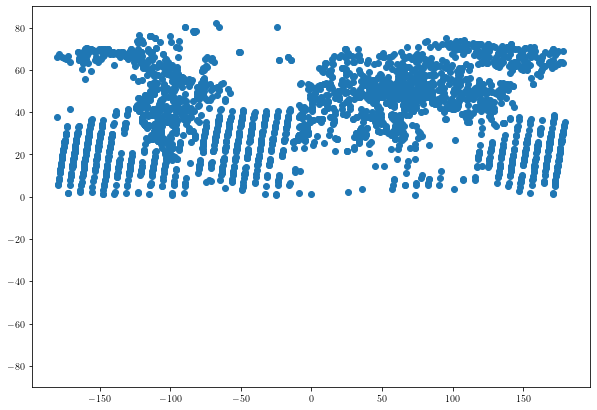

In [28]:
plt.figure(figsize=(10, 7))
plt.scatter(
    gosat_df['lon'][filter1 & filter2],
    gosat_df['lat'][filter1 & filter2]
)
plt.ylim(-90, 90)
plt.show()

In [45]:
TAU = 0.00016
means = np.ones((filter1 & filter2).sum()) * TAU

np.dot(y_tilde[filter1 & filter2], means)

-0.2985946658903116

In [52]:
# draw from that distribution
np.random.seed(123456)
rand_w = stats.multivariate_normal(
    mean=means,
    cov=np.identity((filter1 & filter2).sum()) / np.dot(y_tilde, y_tilde)
).rvs()

In [53]:
# check the value of the functional
np.dot(y_tilde[filter1 & filter2], rand_w)

-0.6771869849394883

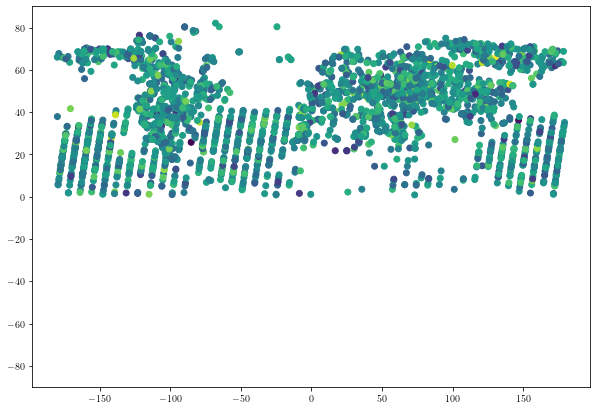

In [54]:
plt.figure(figsize=(10, 7))
plt.scatter(
    gosat_df['lon'][filter1 & filter2],
    gosat_df['lat'][filter1 & filter2],
    c=rand_w
)
plt.ylim(-90, 90)
plt.show()

In [58]:
# construct the vector
w_start = np.zeros(gosat_df.shape[0])

# fill in the elements with the randomly constructed vector
w_start[filter1 & filter2] = rand_w

print(f'Starting value: {np.dot(w_start, y_tilde)}')

Starting value: -0.6771869849394885


#### Save

In [56]:
SAVE_BASE = '/Users/mikestanley/Research/Carbon_Flux/optimization/src_admm'
SAVE_BASE += '/data/carbon_flux/results/19/intermediate_starts'

In [61]:
# saving w starting position
with open(SAVE_BASE + '/w_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=w_start)
    
# saving c starting position
with open(SAVE_BASE + '/c_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=np.zeros(b.shape[0]))
    
# saving lambda starting position
with open(SAVE_BASE + '/lambda_start_it0.npy', 'wb') as f:
    np.save(file=f, arr=np.zeros(A.shape[1]))